In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = '/Users/mi/Docs/RVU/IML/project/Data In CSV/NewFinal.csv'  # Adjust the path if necessary
df = pd.read_csv(file_path)

In [4]:
print("Dataset Overview:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   12486 non-null  object
 1   Sender    12486 non-null  object
 2   Receiver  12486 non-null  object
 3   Date      12486 non-null  object
 4   Body      12486 non-null  object
dtypes: object(5)
memory usage: 487.9+ KB
None

Missing Values:
 Subject     0
Sender      0
Receiver    0
Date        0
Body        0
dtype: int64


In [5]:
df.dropna(inplace=True)
print("\nDataset after dropping NaN rows:")
print(df.info())


Dataset after dropping NaN rows:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12486 entries, 0 to 12485
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Subject   12486 non-null  object
 1   Sender    12486 non-null  object
 2   Receiver  12486 non-null  object
 3   Date      12486 non-null  object
 4   Body      12486 non-null  object
dtypes: object(5)
memory usage: 487.9+ KB
None


In [6]:
print(df.shape)

(12486, 5)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [8]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Take the [CLS] token embedding

In [9]:
df["embeddings"] = df["Body"].apply(lambda x: get_bert_embedding(str(x)))

In [10]:
X = np.vstack(df["embeddings"].values)

In [11]:
# Split dataset into 70% training and 30% testing
X_train, X_test, df_train, df_test = train_test_split(X, df, test_size=0.3, random_state=42)

In [12]:
num_clusters = 10  # Adjust based on dataset
clust_model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
train_clusters = clust_model.fit_predict(X_train)
test_clusters = clust_model.predict(X_test)

In [13]:
print(clust_model.n_iter_)

51


In [14]:
# Add the cluster labels back to the original dataframe
df_train["Cluster"] = train_clusters
df_test["Cluster"] = test_clusters

# Merge the updated data back into df
df = pd.concat([df_train, df_test])

# Save the updated dataframe to CSV
output_file = "/Users/mi/Docs/RVU/IML/project/Data In CSV/Clustered_Emails.csv"
df.to_csv(output_file, index=False)

print(f"Clustered emails saved successfully at: {output_file}")

Clustered emails saved successfully at: /Users/mi/Docs/RVU/IML/project/Data In CSV/Clustered_Emails.csv


In [15]:
silhouette_train = silhouette_score(X_train, train_clusters)
silhouette_test = silhouette_score(X_test, test_clusters)

db_train = davies_bouldin_score(X_train, train_clusters)
db_test = davies_bouldin_score(X_test, test_clusters)

ch_train = calinski_harabasz_score(X_train, train_clusters)
ch_test = calinski_harabasz_score(X_test, test_clusters)

In [16]:
print(f"Silhouette Score - Train: {silhouette_train}, Test: {silhouette_test}")
print(f"Davies-Bouldin Index - Train: {db_train}, Test: {db_test}")
print(f"Calinski-Harabasz Score - Train: {ch_train}, Test: {ch_test}")

Silhouette Score - Train: 0.12268615514039993, Test: 0.12187521159648895
Davies-Bouldin Index - Train: 2.560908958832216, Test: 2.603080396902663
Calinski-Harabasz Score - Train: 509.08839991139286, Test: 213.52182915911783


In [17]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
print(X_train.shape)
print(X_test.shape)

(8740, 768)
(3746, 768)


In [19]:
# Create DataFrame for visualization
train_df = pd.DataFrame({"PC1": X_train_pca[:, 0], "PC2": X_train_pca[:, 1], "Cluster": train_clusters})
test_df = pd.DataFrame({"PC1": X_test_pca[:, 0], "PC2": X_test_pca[:, 1], "Cluster": test_clusters})

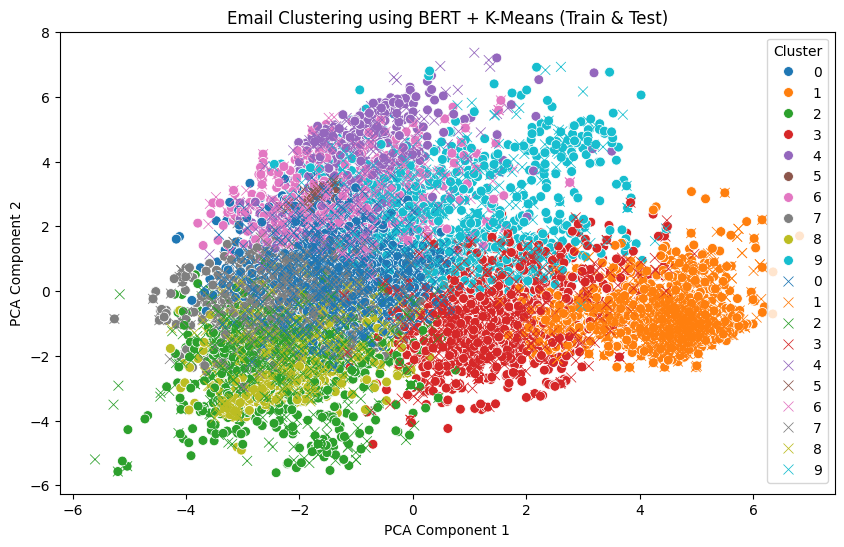

In [20]:
# Plot the clusters
plt.figure(figsize=(10, 6))

# Train data scatter plot
sns.scatterplot(data=train_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=50, marker="o")

# Test data scatter plot
sns.scatterplot(data=test_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=50, marker="x")

plt.title("Email Clustering using BERT + K-Means (Train & Test)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [21]:
print(df.columns)  # Check all column names

Index(['Subject', 'Sender', 'Receiver', 'Date', 'Body', 'embeddings',
       'Cluster'],
      dtype='object')


In [22]:
df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")

In [23]:
df.head()

,Subject,Sender,Receiver,Date,Body,embeddings,Cluster
9981,Notice - Notice Regarding Safety in the Lift,Brigade Panorama Apartments <noreply@nobrokerh...,Mohammed Ismail <mohammedismail0602@gmail.com>,11/28/2024,"NoBrokerHood Email\r\nDear Residents,\r\nWe wi...","[-0.63673484, -0.08052239, -0.07617214, -0.007...",4
4874,"New announcement: """"Please go through the mate...",Ranjan Raj (Classroom) <no-reply@classroom.googl,mohammedi.btech23@rvu.edu.in,8/27/2024,Classroom Logo\r\n''\tNotification settings\r\...,"[-0.28724667, -0.33450547, 0.2836037, -0.01893...",1
3509,ELECTIVE MARKS,SOCSE EA2 <socseea2@rvu.edu.in>,BTech Computer Science And Engineering 2023 <b...,5/29/2024,"Dear Students,\r\nPlease find attached General...","[-0.15300915, -0.3576883, 0.25047204, 0.000546...",7
8090,"New announcement: """"Team Rudra - urgent - eith...",Vaidyanathan Sivasubramanian (Classroom) <no-rep,rakshithak.btech23@rvu.edu.in,12/22/2023,Classroom Logo\r\n''\tNotification settings\r\...,"[-0.40424126, -0.29176363, 0.45439768, -0.1522...",1
2268,GOLDENBRICKS has shared their Hosakerehalli Fl...,Magicbricks <propmb@magicbricks.com>,cjsakshi29@gmail.com,3/01/2024,CJSakshi\r\nNewly posted Hosakerehalli Flats c...,"[-0.34288317, -0.106525294, 0.39676067, -0.596...",0


In [24]:
latest_date = df_train["Date"].max()
print(f"Latest Date in Dataset: {latest_date}")

Latest Date in Dataset: 2025-02-16 00:00:00


In [25]:
latest_date_DF = df_train[df_train["Date"] == latest_date].reset_index(drop=True)

In [26]:
latest_date_DF.to_csv("/Users/mi/Docs/RVU/IML/project/Data In CSV/latest_date_emails.csv", index=False)
print("Latest date emails saved!")

Latest date emails saved!


In [27]:
df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")

# Now filter emails that are not from the latest date
df_remaining = df_train[df_train["Date"] < latest_date].copy()

# Create a 'Month_Year' column
df_remaining["Month_Year"] = df_remaining["Date"].dt.strftime("%B_%Y")

# Group emails by Month_Year
monthly_dfs = {month: group for month, group in df_remaining.groupby("Month_Year")}

# Print available months
print("Available months:", list(monthly_dfs.keys()))

Available months: ['April_2021', 'April_2022', 'April_2023', 'April_2024', 'August_2020', 'August_2021', 'August_2022', 'August_2023', 'August_2024', 'December_2020', 'December_2021', 'December_2022', 'December_2023', 'December_2024', 'February_2021', 'February_2022', 'February_2023', 'February_2024', 'February_2025', 'January_2021', 'January_2022', 'January_2023', 'January_2024', 'January_2025', 'July_2021', 'July_2022', 'July_2023', 'July_2024', 'June_2021', 'June_2022', 'June_2023', 'June_2024', 'March_2021', 'March_2022', 'March_2023', 'March_2024', 'May_2021', 'May_2022', 'May_2023', 'May_2024', 'November_2020', 'November_2021', 'November_2022', 'November_2023', 'November_2024', 'October_2020', 'October_2021', 'October_2022', 'October_2023', 'October_2024', 'September_2020', 'September_2021', 'September_2022', 'September_2023', 'September_2024']


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Define number of clusters
NUM_CLUSTERS = 10  # Adjust based on your data

# Store clustered dataframes
clustered_monthly_dfs = {}

for month, data in monthly_dfs.items():
    print(f"Processing emails for {month}...")

    if len(data) < NUM_CLUSTERS:
        print(f"Skipping {month} as it has only {len(data)} emails, which is less than {NUM_CLUSTERS}.")
        continue  # Skip this month if the number of emails is less than clusters

    # Text vectorization (TF-IDF)
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(data["Body"])

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
    data["Cluster"] = kmeans.fit_predict(X)

    # Save clustered emails
    clustered_monthly_dfs[month] = data

    # Save to CSV (optional)
    data.to_csv(f"/Users/mi/Docs/RVU/IML/project/Data In CSV/new/months/clustered_{month}.csv", index=False)

print("Clustering complete!")

Processing emails for April_2021...
Skipping April_2021 as it has only 5 emails, which is less than 10.
Processing emails for April_2022...
Skipping April_2022 as it has only 8 emails, which is less than 10.
Processing emails for April_2023...
Processing emails for April_2024...
Processing emails for August_2020...
Skipping August_2020 as it has only 9 emails, which is less than 10.
Processing emails for August_2021...
Skipping August_2021 as it has only 8 emails, which is less than 10.
Processing emails for August_2022...
Processing emails for August_2023...
Processing emails for August_2024...
Processing emails for December_2020...
Skipping December_2020 as it has only 1 emails, which is less than 10.
Processing emails for December_2021...
Processing emails for December_2022...
Processing emails for December_2023...
Processing emails for December_2024...
Processing emails for February_2021...
Skipping February_2021 as it has only 3 emails, which is less than 10.
Processing emails for

/Users/mi/Docs/RVU/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Processing emails for November_2024...
Processing emails for October_2020...
Skipping October_2020 as it has only 2 emails, which is less than 10.
Processing emails for October_2021...
Skipping October_2021 as it has only 1 emails, which is less than 10.
Processing emails for October_2022...
Processing emails for October_2023...
Processing emails for October_2024...
Processing emails for September_2020...
Skipping September_2020 as it has only 2 emails, which is less than 10.
Processing emails for September_2021...
Skipping September_2021 as it has only 3 emails, which is less than 10.
Processing emails for September_2022...
Processing emails for September_2023...
Processing emails for September_2024...
Clustering complete!


In [28]:
from transformers import pipeline

# Use DistilBART model for summarization
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6", device=0)  # Use GPU (MPS)

# Function to summarize email bodies
def summarize_text(text):
    if len(text.split()) < 30:  # Skip short texts
        return text
    
    # Truncate long texts to prevent token errors
    truncated_text = " ".join(text.split()[:1000])  # Keep within limit
    input_length = len(truncated_text.split())

    # Dynamically adjust max_length to prevent summarization errors
    max_length = max(10, int(input_length * 0.5))  # Ensures at least 10 words
    min_length = min(30, max_length // 2)  # Adjust min_length to avoid errors

    try:
        summary = summarizer(truncated_text, max_length=max_length, min_length=min_length, do_sample=False)
        return summary[0]["summary_text"]
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return text  # Return original if summarization fails

# Apply summarization to the "Body" column
latest_date_DF["Summary"] = latest_date_DF["Body"].apply(summarize_text)

# Save the summarized emails
save_path = "/Users/mi/Docs/RVU/IML/project/Data In CSV/summerised/summarized_latest_date.csv"
latest_date_DF.to_csv(save_path, index=False)

print(f"Summarized latest date emails saved at {save_path}!")


Device set to use mps:0


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1905 > 1024). Running this sequence through the model will result in indexing errors


Summarized latest date emails saved at /Users/mi/Docs/RVU/IML/project/Data In CSV/summerised/summarized_latest_date.csv!


In [30]:

import pandas as pd

# Load the summarized latest mail CSV
input_file = "/Users/mi/Docs/RVU/IML/project/Data In CSV/summerised/summarized_latest_date.csv"
output_file = "/Users/mi/Docs/RVU/IML/project/Data In CSV/summerised/output_summarized_LD.csv"

# Read the CSV file
df = pd.read_csv(input_file)

# Create a new DataFrame with Mail Number and Summarized Mail (assuming 8th column index is 7)
output_df = pd.DataFrame({
    "Mail_Number": df.index + 1,  # Mail numbers starting from 1
    "Summarized_Mail": df.iloc[:, 7]  # 8th column (index 7)
})

# Save to new CSV file
output_df.to_csv(output_file, index=False)

print(f"✅ Summarized emails saved to {output_file}")


✅ Summarized emails saved to /Users/mi/Docs/RVU/IML/project/Data In CSV/summerised/output_summarized_LD.csv


In [ ]:
# Summarize emails for each clustered month
for month, data in clustered_monthly_dfs.items():
    print(f"Summarizing emails for {month}...")

    # Apply summarization with improved handling
    data["Summary"] = data["Body"].apply(summarize_text)

    # Save summarized emails
    save_path = f"/Users/mi/Docs/RVU/IML/project/Data In CSV/new/summerised/months_summerised/summarized_{month}.csv"
    data.to_csv(save_path, index=False)

    print(f"Summarization complete for {month}! Saved at {save_path}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X' is your data matrix of BERT embeddings

# 1. Explore different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):  # Try clusters from 2 to 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot silhouette scores to visualize the best number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Choose the number of clusters with the highest silhouette score
best_n_clusters = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_n_clusters}")

# 2. Apply K-Means with the best number of clusters and other optimizations
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10, init='k-means++')  # Use 'k-means++' initialization
cluster_labels = kmeans.fit_predict(X)

# 3. Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# 4. Create DataFrame for Visualization
cluster_df = pd.DataFrame({'PC1': X_pca[:, 0], 'PC2': X_pca[:, 1], 'Cluster': cluster_labels})

# 5. Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=50)
plt.title('K-Means Clustering of Email Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()